---

## TSP

The aim of this is to develop a effective solution to solve the [travelling salesman problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem).

The idea of the Travelling Salesman Problem is to find the shortest path necessary to visit all locations and return to the start. For an example of visiting four locations, cycle length is the distance travelled from starting location A to location B, then to location C, then to location D, then back to A. The brute force approach to solving this is consider every possible cycle between the locations, however for N locations there are N! possible cycles so this isn't really tractable for anything above small values like 10.

The following cell generate a random graph with 100 nodes, links the nodes in indices increasing order (to create edges between pair of nodes) and display the resulting solution.

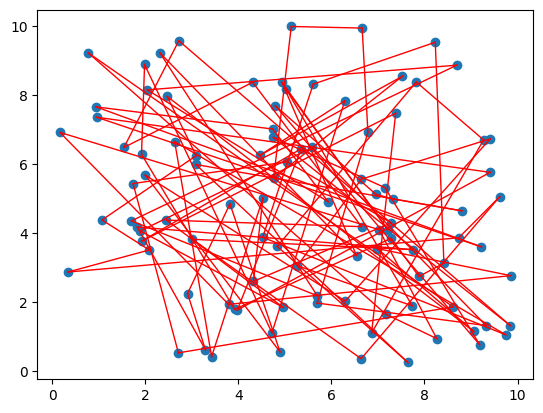

In [17]:
from itertools import permutations
from timeit import timeit

import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange


def create_locations(num, width):
    return np.random.uniform(0, width, (num, 2))

def plot_cycle(locs, cycle):
    x, y = zip(*locs)
    plt.figure()
    plt.scatter(x, y)

    for idx in range(cycle.shape[0]):
        x0, y0 = locs[cycle[idx]]
        x1, y1 = locs[cycle[(idx + 1) % locs.shape[0]]]
        plt.plot([x0, x1], [y0, y1], c="r",linewidth=1)

locs = create_locations(100, 10)
cycle = np.arange(len(locs))
plot_cycle(locs, cycle)

In order to optimise the traveling salesman problem, one need to compute the overall length of the current solution. The following cell provide a numpy based implementation in the `cycle_length_numpy` function.

In [18]:
def cycle_length_numpy(locs,cycle):
    locs_ordered=locs[cycle]
    return np.linalg.norm(locs_ordered - np.roll(locs_ordered, 1, 0), axis=1).sum()


cycle_length_numpy(locs,cycle)
%timeit cycle_length_numpy(locs,cycle)

12 µs ± 436 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Next

Using Numpy requires the creation of a number of extra arrays used for calculation, however an optimised one can be implemented which doesn't need to create any additional arrays but instead accumulates a result value. You should consider this in your implementation and you will be marked on whether you can avoid this extra allocation.

Below is the `cycle_length` function in the following cell. The `cycle_length` function should be optimised in term of computation time when compare to the numpy `cycle_length_numpy` function.

In [21]:
import math
from numba import jit
import torch

@njit
def cycle_length_fast(locs, cycle):
    """
    A numba implementation of the cycle_length function that uses a loop
    instead of numpy.cumsum as the latter is not supported by numba.
    ---------------------------------------------------------------------------
    params:
        locs (np.ndarray): the input array
        cycle (np.ndarray): the input array
    returns:
        np.ndarray: the result array
    """
    result = 0
    for i in prange(len(cycle)):
        x1, y1 = locs[cycle[i]]
        x2, y2 = locs[cycle[(i + 1) % len(cycle)]]
        result += ((x2 - x1) ** 2) + ((y2 - y1) ** 2) ** 0.5
    return result

@njit(parallel=True, fastmath=True)
def cycle_length_fast_parallel(locs, cycle):
    """
    A similar numba implementation of the cycle_length function that uses the 
    parallel option to speed up the loop. This is a little bit slower than the
    previous implementation, but it is faster on larger arrays.
    ---------------------------------------------------------------------------
    params:
        locs (np.ndarray): the input array
        cycle (np.ndarray): the input array
    returns:
        np.ndarray: the result array
    """
    result = 0
    for i in prange(len(cycle)):
        x1, y1 = locs[cycle[i]]
        x2, y2 = locs[cycle[(i + 1) % len(cycle)]]
        result += ((x2 - x1) ** 2) + ((y2 - y1) ** 2) ** 0.5
    return result

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # in this case I am using a GPU
locs_tensor = torch.from_numpy(locs).to(device)
cycle_tensor = torch.from_numpy(cycle).long().to(device)

@torch.cuda.amp.autocast()
def cycle_length_fast_tensor(locs, cycle):
    """
    A torch implementation of the cycle length function, although it is not
    faster than the numpy version on small arrays, but will be faster on large
    arrays.
    ---------------------------------------------------------------------------
    params:
        locs (torch.Tensor): the input array of locations
        cycle (torch.Tensor): the input array of cycle
    returns:
        torch.Tensor: the result array that is on the same device as the input
    """
    locs = locs[cycle]
    x, y = locs[:, 0], locs[:, 1]
    x_shift, y_shift = torch.roll(x, 1), torch.roll(y, 1)
    return torch.sum(torch.sqrt((x - x_shift) ** 2 + (y - y_shift) ** 2))

%timeit cycle_length_fast(locs, cycle)
%timeit cycle_length_fast_parallel(locs, cycle)
%timeit cycle_length_fast_tensor(locs_tensor, cycle_tensor)

575 ns ± 6.78 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
The slowest run took 6.82 times longer than the fastest. This could mean that an intermediate result is being cached.
41.1 µs ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
156 µs ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Cycle length threaded

In [9]:
import queue
import threading

def cycle_length_thread(locs, cycle):
    """
    A thread implementation of the cycle length calculation. Each thread will
    calculate the length of a chunk of the cycle. The results will be stored in
    a queue and the main thread will sum up the results.
    ---------------------------------------------------------------------------
    params:
        locs (np.ndarray): the locations of the points
        cycle (np.ndarray): the cycle index
    returns:
        float: the length of the cycle
    """
    num_chunks = 5  # Change the number of threads here

    # divide the number of cycles into num_threads and make sure the sum of the number of cycles is equal to the total number of cycles
    num_per_chunk = len(cycle) // num_chunks
    num_last_chunk = len(cycle) - (num_chunks - 1) * num_per_chunk
    num_chunk_list = [num_per_chunk] * (num_chunks - 1) + [num_last_chunk]
    chunk_list = np.split(cycle, np.cumsum(num_chunk_list))[:-1]

    # Create a queue to store the results from each thread
    results_queue = queue.Queue()

    # Define a helper function to compute the sum of Euclidean distances for a chunk of the cycle

    def compute_chunk_sum(chunk):
        locs_ordered = locs[chunk]
        # chunk_sum = np.linalg.norm(locs_ordered - np.roll(locs_ordered, 1, 0), axis=1).sum()
        # compute the sum without connecting the first and last points
        chunk_sum = np.linalg.norm(locs_ordered - np.roll(locs_ordered, 1, 0), axis=1)
        chunk_sum[0] = 0
        chunk_sum = chunk_sum.sum()
        results_queue.put(chunk_sum)

    # Create a list of threads
    threads = []

    # Start a new thread for each chunk of the cycle
    for chunk in chunk_list:
        thread = threading.Thread(target=compute_chunk_sum, args=(chunk,))
        thread.start()
        threads.append(thread)

    # Wait for all threads to complete
    for thread in threads:
        thread.join()

    total_sum = 0

    while not results_queue.empty():
        total_sum += results_queue.get()

    # for each chunk, add the distance between the first and last point to the next chunk
    for i in range(len(chunk_list) - 1):
        total_sum += np.linalg.norm(locs[chunk_list[i][-1]] - locs[chunk_list[i + 1][0]])
    
    # add the distance between the first and last point of chunk_list[0] and chunk_list[-1]
    total_sum += np.linalg.norm(locs[chunk_list[0][0]] - locs[chunk_list[-1][-1]])

    # # Return the total sum
    return np.array(total_sum)

print(cycle_length_thread(locs, cycle))
%timeit cycle_length_thread(locs, cycle)

556.5450628187416
1.61 ms ± 8.66 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Question 5 [10 marks]

Times for runs of the three versions of the algorithm are calculated below and plotted. At certain points one version of the algorithm or another becomes the fastest, why is this? Specifically at what point does the threaded version become fastest and why?

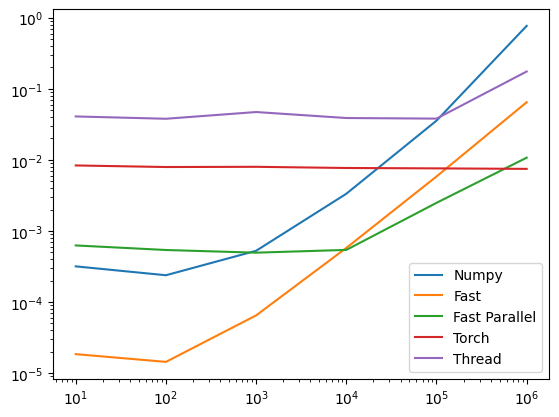

In [22]:
loc_sizes = [10, 100, 1_000, 10_000, 100_000, 1_000_000]
locs = create_locations(loc_sizes[-1], 10)
cycle = np.arange(loc_sizes[-1])

locs_tensor = torch.from_numpy(locs).to(device)
cycle_tensor = torch.from_numpy(cycle).long().to(device)

numpy_times = [timeit(lambda: cycle_length_numpy(locs, cycle[:n]), number=20) for n in loc_sizes]
fast_times = [timeit(lambda: cycle_length_fast(locs, cycle[:n]), number=20) for n in loc_sizes]
fast_parallel_times = [timeit(lambda: cycle_length_fast_parallel(locs, cycle[:n]), number=20) for n in loc_sizes]
fast_torch_times = [timeit(lambda: cycle_length_fast_tensor(locs_tensor, cycle_tensor[:n]), number=20) for n in loc_sizes]
thread_times = [timeit(lambda: cycle_length_thread(locs, cycle[:n]), number=20) for n in loc_sizes]

plt.loglog(loc_sizes, numpy_times, label="Numpy")  # Numpy is the baseline
plt.loglog(loc_sizes, fast_times, label="Fast")  # Numba is faster than numpy
plt.loglog(loc_sizes, fast_parallel_times, label="Fast Parallel") # Numba with parallel, slower at small sizes but faster at large sizes
plt.loglog(loc_sizes, fast_torch_times, label="Torch GPU") # Torch constant time regardless of size
plt.loglog(loc_sizes, thread_times, label="Thread") # Thread is slower than numpy before 10^5, but faster after 10^5
plt.legend()


*The threading version was the slowest at first, but it eventually caught up to the numpy between 10^4 and 10^5 loc sizes, but it never caught up to the numba version, likely due to the overhead of creating and managing threads. When the number of locations is small, the time of overhead takes up a significant portion of the runtime, making the threaded version slower than the others. As the size increases, the amount of time spent on the actual calculations becomes more significant, and the threaded version is able to catch up to the numpy version. However, the numba version is able to optimise the calculations to such a degree that it remains faster than the threaded version even at larger sizes. This is because it is able to make use of specialised, optimised code paths and hardware acceleration (e.g., using SIMD instructions) that are not available in the threaded version. It is possible that the torch version remains at a consistent runtime even as the size of the locations increases because it is able to make use of GPU acceleration, which can greatly improve the performance of certain types of calculations.*

A number of approaches exist to find a good cycle for non-trivial location sizes. There are exact algorithms that are faster than brute force but are still NP-hard. A approximate solution involves some technique to find a good solution in some defined manner that's better than just chance. The implementation below uses a genetic algorithm approach to start from an initial cycle (parent) and modify parts of it in a randomised way a set number of times. From the generated cycles (offspring) the shortest is chosen to be the parent of the next generation. This has similarities to genetic mutations in real organisms but simplifies the concepts immensely but allows one to start from one solution and attempt to find a nearby better solution, ultimately with the hope of converging onto a final solution that's close to an actual optimum. This approach is relatively simple and attractive for attacking real-world problems with intractable algorithmic solutions. See: https://en.wikipedia.org/wiki/Genetic_algorithm

Below is the brute force solution to the problem, don't run this with locations counts above 10 because it will take enormous amounts of time to finish:

26.53400670504084


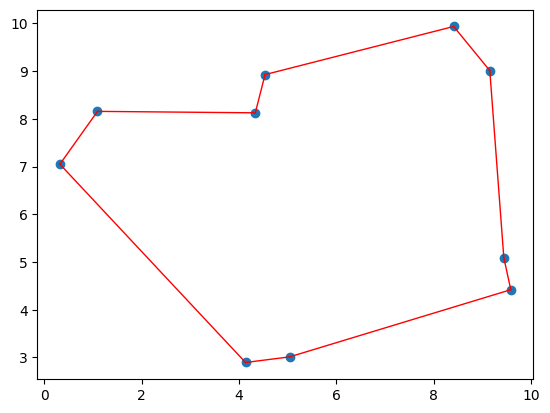

In [23]:
def find_best_cycle_bf(locs):
    """Try all possible cycles for the given locations, this will take longer than the age of the universe for even trivial sets."""
    nlocs = len(locs)
    indices = np.arange(nlocs)
    min_len = float("inf")
    result = None

    for p in permutations(np.arange(nlocs), nlocs):
        indices[:] = p
        # modify the cycle length to use your fastest implementation
        clen = cycle_length_numpy(locs, indices)
        if clen < min_len:
            min_len = clen
            result = p

    return result

test_locs = create_locations(10, 10)
best = find_best_cycle_bf(test_locs)
print(cycle_length_numpy(test_locs, np.array(best)))
plot_cycle(test_locs, np.array(best))

### Genetic algorithm approach

Below is the solution using a genetic algorithm approach. For a set number of iterations, a starting cycle is mutated a randomised number of times to produce a number of offspring. From these the shortest path is chosen as the new parent and all others go extinct. 

In [12]:
def generate_mutation(cycle, num_changes):
    """Given a cycle, apply `num_changes` mutations to the cycle and return the mutant."""
    cycle = cycle.copy()

    for _ in range(np.random.randint(1, num_changes)):
        i,j = np.random.randint(0, len(cycle),(2,))
        cycle[i], cycle[j] = cycle[j], cycle[i]

    return cycle

generate_mutation(cycle,10)

%timeit generate_mutation(cycle,10)

156 µs ± 6.65 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [13]:
import random

@njit(nogil=True, fastmath=True)  # add no gil for later use of threading
def generate_mutation_fast(cycle, num_changes):
    """
    Given a cycle, apply `num_changes` mutations to the cycle and return the
    mutant. This is a faster version of the generate_mutation function. It uses
    the random.randint function instead of np.random.randint for cases where
    only a single value is needed.
    ---------------------------------------------------------------------------
    params:
        cycle (np.ndarray): the cycle
        num_changes (int): the number of changes to make
    returns:
        np.ndarray: the mutated cycle
    """
    cycle_copy = cycle.copy()
    # for a single value, this is faster than np.random.randint
    num_mutations = random.randint(1, num_changes + 1)
    # preallocate the indices array to avoid the overhead of creating a new array each time
    indices = np.random.randint(0, len(cycle_copy), size=(num_mutations, 2))
    for i, j in indices:
        cycle_copy[i], cycle_copy[j] = cycle_copy[j], cycle_copy[i]
    return cycle_copy

generate_mutation_fast(cycle,10)

%timeit generate_mutation_fast(cycle,10)

121 µs ± 4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


100%|██████████| 20000/20000 [34:42<00:00,  9.60it/s]


Time: 2082.8327802000567, Best length: 14897169.776061155


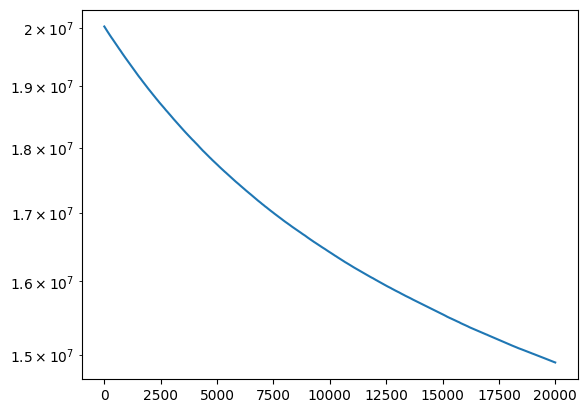

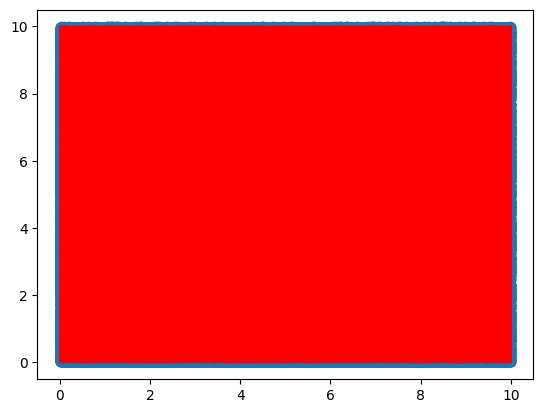

In [24]:
from tqdm import tqdm
import queue
import threading
from timeit import timeit

"""
This is implemented with:
    1. generate_mutation_fast with numba and no gil + threading
    2. cycle_length_fast which is the fastest version of the cycle_length function
    3. the torch version is not used here because it is not faster than the numba version on my machine
"""


def generate_mutation_fast_thread(current_cycle, num_changes, queue_, num_offspring):
    """ 
    Generate a number of mutants (i.e., modified copies of some original item)
    using a function called generate_mutation_fast(). It takes as input the
    current cycle and the number of changes to make, and it generates
    num_offspring number of mutants. The mutants are then added to a queue
    using the queue_.put() method. This allows other parts of the program to
    access the mutants as they become available, potentially in a separate
    thread of execution.
    ---------------------------------------------------------------------------
    params:
        current_cycle (np.array): current cycle of the points
        num_changes (int): number of changes to make to the current cycle
        queue_ (queue.Queue): queue to store the mutants
        num_offspring (int): number of mutants to generate
    """
    mutants = [generate_mutation_fast(current_cycle, num_changes) for _ in range(num_offspring)]
    queue_.put(mutants)


def find_better_cycle(locs, init_cycle, num_iterations, num_offspring, num_changes):
    current_cycle = init_cycle
    iterlengths = []
    num_threads = 4
    queue_mutation = queue.Queue()

    # divide the number of offspring into num_threads and make sure the sum of the offspring is equal to num_offspring
    num_offspring_per_thread = num_offspring // num_threads
    num_offspring_last_thread = num_offspring - (num_threads - 1) * num_offspring_per_thread
    num_offspring_per_thread_list = [num_offspring_per_thread] * (num_threads - 1) + [num_offspring_last_thread]

    for _ in tqdm(range(num_iterations)):
        threads_mutation = []

        for i in num_offspring_per_thread_list:
            t = threading.Thread(target=generate_mutation_fast_thread, args=(current_cycle, num_changes, queue_mutation, i))
            t.start()
            threads_mutation.append(t)

        for t in threads_mutation:
            t.join()

        # Get the results from the queue
        offspring = []
        while not queue_mutation.empty():
            offspring += queue_mutation.get()

        # offspring = np.array(offspring)
        family = [current_cycle] + offspring

        # modify the cycle length to use your fastest implementation
        lengths = np.array([cycle_length_fast_parallel(locs, c) for c in family])

        idx = np.argmin(lengths)

        current_cycle = family[idx]
        iterlengths.append(lengths[idx])

    return current_cycle, iterlengths


new_cycle = None
new_lengths = None


def _timeit_func():
    global new_cycle
    global new_lengths

    new_cycle, new_lengths = find_better_cycle(
        locs=locs, init_cycle=cycle, num_iterations=20000, num_offspring=100, num_changes=40
    )


tval = timeit(_timeit_func, number=1, globals=globals())

print(f"Time: {tval}, Best length: {new_lengths[-1]}")

plt.semilogy(new_lengths)
plot_cycle(locs, new_cycle)


### Cluster Approach (main work)

In [29]:
%%writefile tsp.py

"""
In order to utilize the full computational resources of a system, I use the multiprocessing module to distribute tasks across multiple cores. However, this module is not compatible with the Jupyter notebook environment. Therefore, I use the %%write_file magic command to write the code to an external file, which can then be executed outside of the notebook. This allows us to take advantage of multiprocessing while still maintaining the convenience of writing and testing code within the notebook. The output is produced in the next cell.

To improve the overall computation time for a better result (shortest path), I apply clustering to the genetic algorithm: There are several reasons why clustering may be useful in the application of a genetic algorithm for the Traveling Salesman Problem (TSP). Firstly, clustering allows for the reduction of the number of locations being processed by the genetic algorithm. This can significantly reduce the computational time required for the algorithm to run, as the genetic algorithm becomes more efficient when working with a smaller number of locations. Secondly, clustering can also help to improve the accuracy and quality of the solution found by the genetic algorithm. By breaking the locations into clusters and applying the genetic algorithm to each cluster separately, the algorithm can more effectively optimize the local structure of each cluster, leading to a more accurate and high-quality solution. Finally, clustering can also be used to parallelize the genetic algorithm, allowing it to run on multiple cores or processors simultaneously. This can further reduce the computational time required for the algorithm to run.

In addition to the benefits mentioned above, clustering can also help to mitigate the issue of premature convergence in a genetic algorithm. By breaking the locations into clusters and applying the genetic algorithm to each cluster separately, the algorithm can explore a greater variety of solutions, rather than getting stuck in a local minimum. This can lead to a more diverse and robust population of solutions, reducing the risk of premature convergence and improving the overall performance of the genetic algorithm for the TSP.
"""


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import multiprocessing as mp
import time
import queue
import numpy as np
import threading
from numba import njit, prange
from tqdm import tqdm
from matplotlib import pyplot as plt
import random


def cpaste(test: str, color: str):
    """
    Color paste text to terminal outpu, for example: print(f"{cpaste('hello',
    'red')} world") will print hello in red
    ---------------------------------------------------------------------------
    """
    color_dict = {
        "red": "\033[91m",
        "green": "\033[92m",
        "yellow": "\033[93m",
        "blue": "\033[94m",
        "magenta": "\033[95m",
        "cyan": "\033[96m",
        "white": "\033[97m",
        "black": "\033[98m",
        "end": "\033[0m",
    }
    return f"{color_dict[color]}{test}{color_dict['end']}"

def create_locations(num, width):
    return np.random.uniform(0, width, (num, 2))

def plot_cycle(locs, cycle):
    x, y = zip(*locs)
    plt.figure()
    plt.scatter(x, y)

    for idx in range(cycle.shape[0]):
        x0, y0 = locs[cycle[idx]]
        x1, y1 = locs[cycle[(idx + 1) % locs.shape[0]]]
        plt.plot([x0, x1], [y0, y1], c="r",linewidth=1)

@njit # the parallel decorator won't work here because this function will be part of a multiprocessing pool
def cycle_length_fast(locs, cycle):
    """
    A numba implementation of the cycle_length function that uses a loop
    instead of numpy.cumsum as the latter is not supported by numba.
    ---------------------------------------------------------------------------
    params:
        locs (np.ndarray): the input array
        cycle (np.ndarray): the input array
    returns:
        np.ndarray: the result array
    """
    result = 0
    for i in prange(len(cycle)):
        x1, y1 = locs[cycle[i]]
        x2, y2 = locs[cycle[(i + 1) % len(cycle)]]
        result += ((x2 - x1) ** 2) + ((y2 - y1) ** 2) ** 0.5
    return result


@njit(nogil=True, fastmath=True)  # add no gil for later use of threading
def generate_mutation_fast(cycle, num_changes):
    """
    Given a cycle, apply `num_changes` mutations to the cycle and return the
    mutant. This is a faster version of the generate_mutation function. It uses
    the random.randint function instead of np.random.randint for cases where
    only a single value is needed.
    ---------------------------------------------------------------------------
    params:
        cycle (np.ndarray): the cycle
        num_changes (int): the number of changes to make
    returns:
        np.ndarray: the mutated cycle
    """
    cycle_copy = cycle.copy()
    # for a single value, this is faster than np.random.randint
    num_mutations = random.randint(1, num_changes + 1)
    # preallocate the indices array to avoid the overhead of creating a new array each time
    indices = np.random.randint(0, len(cycle_copy), size=(num_mutations, 2))
    for i, j in indices:
        cycle_copy[i], cycle_copy[j] = cycle_copy[j], cycle_copy[i]
    return cycle_copy



def find_better_cycle(locs, init_cycle, num_iterations, num_offspring, num_changes):
    """
    This is a modified version of the genetic algorithm that is used to find a
    better cycle. The following changes were made:
        - The cycle length is calculated using the numba implementation
        - The mutation is calculated using the numba implementation
        - an early stopping condition was added
        - last improvement is calculated using numpy
        - np.argmin is used to find the index of the best cycle
    ---------------------------------------------------------------------------
    params:
        locs (np.array): locations of the points
        init_cycle (np.array): initial cycle of the points
        num_iterations (int): number of iterations to run the genetic algorithm
        num_offspring (int): number of offspring to generate per iteration
        num_changes (int): number of changes to make to the cycle per mutation
    returns:
        current_cycle (np.array): best cycle found
        iter_lengths (np.array): array of cycle lengths for each iteration
        num_iterations (int): number of iterations run
    """
    current_cycle = init_cycle
    iter_lengths = []

    for i in range(num_iterations):
        try:
            # find the number of iterations since the last improvement
            num_last_improvement = len(iter_lengths) - np.argmin(iter_lengths) - 1
        except ValueError:
            # cases where the first iteration is the best
            num_last_improvement = 0

        offspring = [generate_mutation_fast(current_cycle, num_changes) for _ in range(num_offspring)]

        family = [current_cycle] + offspring

        # the threading trick above does not make the lengths faster so it is not used here
        lengths = np.array([cycle_length_fast(locs, c) for c in family])

        idx = np.argmin(lengths)
        current_cycle = family[idx]
        iter_lengths.append(lengths[idx])

        # early stopping condition if the best cycle has not improved in 512 iterations
        if num_last_improvement > 512:
            return current_cycle, iter_lengths, i

    return current_cycle, iter_lengths, num_iterations


def attach_cluster(to_locs, from_locs, from_cycle):
    """
    This function takes two clusters and tries to attach them together. This
    is for attaching adjacent clusters when breaking the locations into
    clusters.
    ---------------------------------------------------------------------------
    params:
        from_locs: locations of the first cluster
        from_cycle: cycle of the first cluster
        to_locs: locations of the second cluster
    """
    # the the coordinates of the first element of the to cycle
    to_point = to_locs[0]
    # find the index of the element in the from_cycle that is closest to the to_point
    from_point_index = np.argmin(np.linalg.norm(from_locs - to_point, axis=1))
    # roll the from_cycle so that the from_point_index is the first element
    from_cycle = np.roll(from_cycle, -from_point_index)
    return from_cycle


class GeneticAlgorithm:
    def __init__(self, size_locs, total_num_iterations):
        """
        The GeneticAlgorithm class contains methods for implementing a genetic
        algorithm to solve the Traveling Salesman Problem. Its main method, main(),
        takes in locations (locs), current cycle of the points, number of locations
        per cluster, and total number of iterations. It breaks the locations into
        clusters and runs the find_better_cycle method in parallel on each cluster
        locally using the multiprocessing library. The find_better_cycle method
        uses a genetic algorithm to find a better cycle for the points in a given
        cluster. The main method also updates a progress bar to track the progress
        of the algorithm. The break_to_clusters method is a helper function that
        breaks the locations into clusters and returns the clusters and their
        order.
        ---------------------------------------------------------------------------
        params:
            size_locs (int): the number of locations for progress bar
            total_num_iterations (int): the total number of iterations for the
                algorithm
        """
        self.total_num_batches = 0
        self.main_cycle = True
        self.size_locs = size_locs  # initial record of the size of the locs array for progress bar
        self.total_num_iterations = total_num_iterations  # initial record of the total number of iterations for progress bar

    def main(self, locs, cycle, num_locs_per_cluster):
        """
        The main method of the GeneticAlgorithm class performs the following actions:
            1. It divides the input locs into clusters.
            2. It runs the find_better_cycle method in parallel on each cluster using
                the multiprocessing library.
            3. If the number of clusters is greater than the input num_locs_per_cluster,
                the method further divides the clusters into smaller clusters in a loop
                until the number of clusters is less than or equal to num_locs_per_
                cluster.
            4. It combines the clusters by rolling them so that the first element of
                each cluster is the closest element to the first element of the
                previous cluster.
            5. It returns the modified cycle and locs.
        ---------------------------------------------------------------------------
        params:
            locs (np.array): locations of the points
            cycle (np.array): current cycle of the points
            num_locs_per_cluster (int):
                number of locations per cluster, minimum 2. The smaller the number
                the more clusters will be created and more accurate the result will be.
                But the computation time will increase exponentially.
        returns:
            cycle (np.array): new cycle of the points
            locs (np.array): new locations of the points
        """
        # break the locations into clusters
        num_clusters = np.ceil(len(locs) / num_locs_per_cluster).astype(int)
        # calculate the total number of batches
        self.total_num_batches += np.ceil(num_clusters / mp.cpu_count()).astype(int)
        # break the locations into clusters
        locs_clusters, cycle_clusters, cluster_order = self.break_to_clusters(locs, cycle, num_clusters, num_locs_per_cluster)
        # run the find_better_cycle method in parallel on each cluster
        num_iterations_per_cluster = self.total_num_iterations // num_clusters

        # if this is the first time running the main method, then print the number of batches and the number of cores
        if self.main_cycle:
            print("-" * 2**6)
            print(
                f"Total number of batches: {cpaste(self.total_num_batches, 'yellow')} | Locs size: {cpaste(self.size_locs, 'yellow')} | Using {cpaste(mp.cpu_count(), 'yellow')} cores"
            )
            self.progress_bar = tqdm(range(self.total_num_batches), colour="green")
            self.batches_iter = iter(range(self.total_num_batches))
            self.main_cycle = False

        # init the results array
        results = []

        # calculate the number of batches by dividing the number of clusters by the number of cores
        num_batches = np.ceil(num_clusters / mp.cpu_count()).astype(int)

        for batch in range(num_batches):
            with mp.Pool(mp.cpu_count()) as pool:  # use all available cores
                results += pool.starmap(
                    find_better_cycle,
                    [
                        (
                            locs_clusters[cluster],
                            np.arange(len(locs_clusters[cluster])),
                            num_iterations_per_cluster,
                            2**6,
                            2**1,  # set a low mutation rate as the clusters are already close to the optimal solution
                        )
                        for cluster in range(batch * mp.cpu_count(), min((batch + 1) * mp.cpu_count(), num_clusters))
                    ],
                )
            current_batch = self.batches_iter.__next__()
            iterations_ran = sum((result[2] for result in results))
            self.progress_bar.set_description(
                f"Batch {cpaste(current_batch + 1, 'red')} | Planned Iterations: {cpaste(int(self.total_num_iterations / self.total_num_batches * (current_batch + 1)), 'red')} | Iterations ran (early stopping): {cpaste(iterations_ran, 'red')}"
            )
            self.progress_bar.update(1)

        new_cycle = [i[0] for i in results]
        new_cycle = [cycle_clusters[cluster][new_cycle[cluster]] for cluster in cluster_order]
        for cluster in range(num_clusters - 1):
            new_cycle[cluster + 1] = attach_cluster(
                locs_clusters[cluster_order[cluster]],
                locs_clusters[cluster_order[cluster + 1]],
                new_cycle[cluster + 1],
            )
        new_cycle = np.concatenate(new_cycle)

        # finally run the find_better_cycle method on the entire set of locations
        # to make sure remove any local minima
        new_cycle, _, _ = find_better_cycle(locs, new_cycle, 999999, 2**6, 2**1)

        # calculate the length of the new cycle
        length = cycle_length_fast(locs, new_cycle)

        return new_cycle, length

    def break_to_clusters(self, locs, cycle, num_clusters, num_locs_per_cluster):
        """
        This function breaks the locations into clusters and returns the clusters
        and the order of the clusters. This is for breaking the locations into
        clusters before running the genetic algorithm. This is done to reduce
        the number of locations in the genetic algorithm.

        params:
            locs (np.array): locations of the points
            cycle (np.array): cycle of the points
            num_clusters (int): number of clusters to break the locations into
            num_locs_per_cluster (int): number of locations per cluster
        returns:
            locs_clusters (np.array): array of arrays of locations of the clusters
            cycle_clusters (np.array): array of arrays of cycles of the clusters
            cluster_order (np.array): order of the clusters
        """
        # scale the coordinates to be between 0 and 1 and then cluster them
        scaler = StandardScaler()
        locs_scaled = scaler.fit_transform(locs)
        kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(locs_scaled)
        locs_clusters_index = kmeans.predict(locs_scaled)

        # divide the coordinates into clusters from 0 to max (array of arrays of a size 8)
        locs_clusters = np.array([locs[locs_clusters_index == cluster] for cluster in range(num_clusters)], dtype=object)
        cycle_clusters = np.array([cycle[locs_clusters_index == cluster] for cluster in range(num_clusters)], dtype=object)
        centers_locs = np.array([np.mean(locs_clusters[cluster], axis=0) for cluster in range(num_clusters)])

        # find the order of the clusters by viewing them as a graph and finding the shortest path
        # if the number of clusters is less than the number of locations per cluster, then
        # just feed back the original cycle for further dimensionality reduction, otherwise
        # find the order of the clusters
        centers_cycle = np.arange(len(centers_locs))
        if len(centers_locs) > num_locs_per_cluster:  # if the number of clusters is greater than the number of locations per cluster further reduce the number of clusters
            cluster_order, _ = self.main(centers_locs, centers_cycle, num_locs_per_cluster)
        else:
            cluster_order, _, _ = find_better_cycle(centers_locs, centers_cycle, 999999, 2**6, 2**1)
        return locs_clusters, cycle_clusters, cluster_order




Overwriting tsp.py


----------------------------------------------------------------
Total number of batches: 4 | Locs size: 100 | Using 16 cores


Batch 4 | Planned Iterations: 2000000 | Iterations ran (early stopping): 12862: 100%|██████████| 4/4 [00:09<00:00,  2.53s/it]

↓ Time: 10.23 seconds, Best length: 97.672 ↓


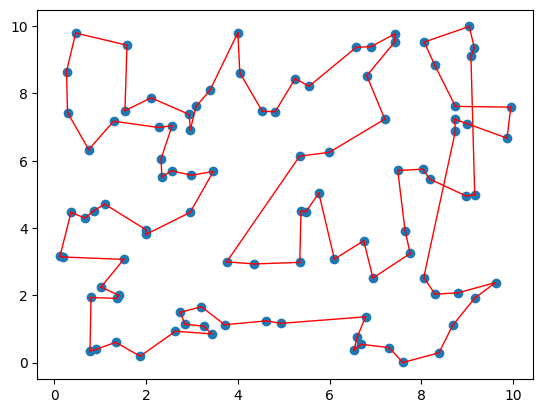

Batch 4 | Planned Iterations: 2000000 | Iterations ran (early stopping): 12862: 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


----------------------------------------------------------------
Total number of batches: 22 | Locs size: 1000 | Using 16 cores


Batch 22 | Planned Iterations: 2000000 | Iterations ran (early stopping): 129936: 100%|██████████| 22/22 [01:12<00:00,  3.10s/it]

↓ Time: 79.684 seconds, Best length: 248.129 ↓


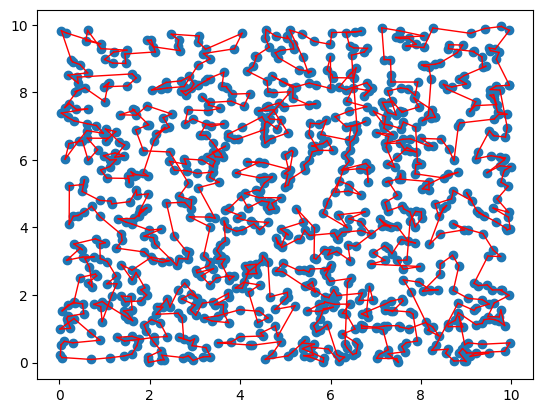

Batch 22 | Planned Iterations: 2000000 | Iterations ran (early stopping): 129936: 100%|██████████| 22/22 [01:20<00:00,  3.64s/it]


----------------------------------------------------------------
Total number of batches: 44 | Locs size: 10000 | Using 16 cores


Batch 44 | Planned Iterations: 2000000 | Iterations ran (early stopping): 428554: 100%|██████████| 44/44 [02:30<00:00,  2.90s/it]

↓ Time: 151.679 seconds, Best length: 799.504 ↓


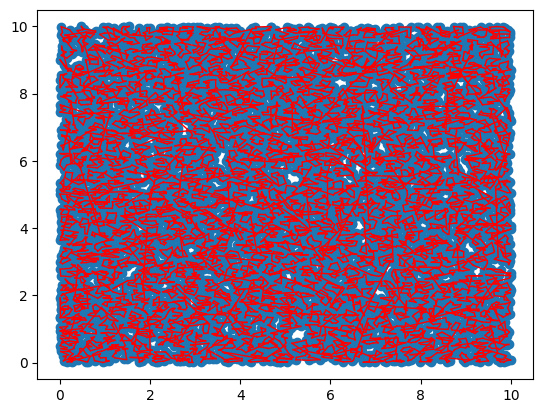

Batch 44 | Planned Iterations: 2000000 | Iterations ran (early stopping): 428554: 100%|██████████| 44/44 [02:34<00:00,  3.52s/it]


----------------------------------------------------------------
Total number of batches: 50 | Locs size: 100000 | Using 16 cores


Batch 50 | Planned Iterations: 2000000 | Iterations ran (early stopping): 1989238: 100%|██████████| 50/50 [03:12<00:00,  3.68s/it]

↓ Time: 212.832 seconds, Best length: 2901.74 ↓


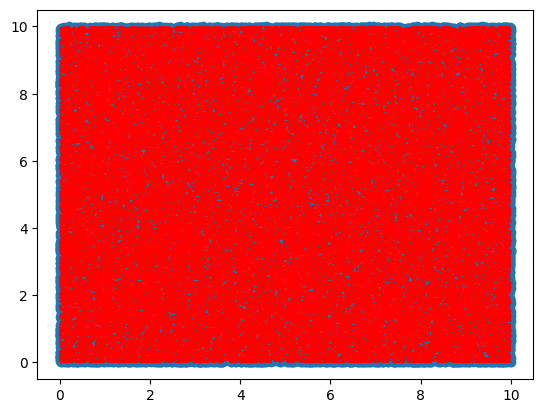

Batch 50 | Planned Iterations: 2000000 | Iterations ran (early stopping): 1989238: 100%|██████████| 50/50 [03:58<00:00,  4.76s/it]


----------------------------------------------------------------
Total number of batches: 246 | Locs size: 1000000 | Using 16 cores


Batch 246 | Planned Iterations: 2000000 | Iterations ran (early stopping): 1996477: 100%|██████████| 246/246 [13:54<00:00,  2.78s/it]

↓ Time: 1699.533 seconds, Best length: 15291.835 ↓


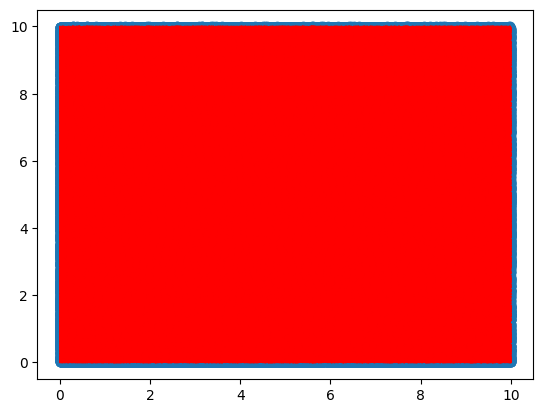

In [2]:
"""On my machine the njit will sometimes fails to compile without an error message (5% chance). If that happens, please try running the cell again."""
from tsp import GeneticAlgorithm, cpaste, create_locations, plot_cycle
import time
import numpy as np
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # show the result for different number of locations
    loc_sizes = [100, 1_000, 10_000, 100_000, 1_000_000]
    for i in loc_sizes:
        locs = create_locations(i, 10)
        cycle = np.arange(i)
        # define the number of locations per cluster
        # number of locations per cluster, minimum 2. The smaller the number the more clusters will be created and more accurate the result will be. But the computation time will increase exponentially. So for large number of locations, it is better to keep the number of locations relatively larger. For small numbers of locations, we can afford to keep the number of locations per cluster smaller.
        match i:
            case 100:
                num_locs_per_cluster = 2**2  # smaller = more clusters = more accurate = more time
            case 1_000:
                num_locs_per_cluster = 2**2
            case 10_000:
                num_locs_per_cluster = 2**4
            case 100_000:
                num_locs_per_cluster = 2**7
            case 1_000_000:  # at my 16 core machine, this takes about 13 minutes to run
                num_locs_per_cluster = 2**8  # smaller = more clusters = more accurate = more time
        tval = time.time()
        process_ = GeneticAlgorithm(len(locs), total_num_iterations=2000000)
        new_cycle, length = process_.main(locs, cycle, num_locs_per_cluster)
        tval = time.time() - tval
        # because the map is divided and processed as many small local batches, we don't obtain the semilogy plot here (since the global length is not computed at each batch) as we did in the previous case. But we can still plot the cycle and see the result.
        print(f"↓ Time: {cpaste(tval.__round__(3), 'green')} seconds, Best length: {cpaste(length.__round__(3), 'green')} ↓")
        plot_cycle(locs, new_cycle)
        plt.show()

## Reference:
[1] https://www.python.org/dev/peps/pep-0008

[2] https://www.w3schools.com/python/python_lists_comprehension.asp

[3] https://realpython.com/python-comments-guide/

[4] https://www.kcl.ac.uk/aboutkings/orgstructure/ps/acservices/conduct/academic-misconduct
